Imports...
We chose to go with urllib instead of wget because we want to specify file save location.

In [14]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import urllib3

plt.rcParams.update({'figure.max_open_warning': 0})


Fetching the data with urllib, converting it from text
We use a list of dataset configs to help us save the data and preprocess it.
The config is different for each file extension.
config = [
    {
    'name': str,
        'url': str,
        'file_extension': 'xls | arr ',
        'id': int,
        &unique properties
    }
]

unique properties:
'xls' -> 'sheet_names': str[]

In [15]:
DATASET_CONFIGS = [
    {
        'name': 'credit_card_defaults',
        'url': 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls',
        'sheet_names': ['Data'],
        'file_extension': 'xls',
        'id': 1
    }
]

BASE_PATH = 'data'

class DataLoader:
    """
    Loads various data formats and converts them to csv by using a config dictionary.
    config = {'file_extension': ['download_url']}
    """
    def __init__(self, config):
        self.config = config
        self.http = urllib3.PoolManager()
        self.base_path = BASE_PATH

        if not os.path.exists(self.base_path):
            os.mkdir(self.base_path)

    def fetch_data(self, url, dataset_name, file_ext):
        dataset_dir = f'{self.base_path}/{dataset_name}'
        if not os.path.exists(dataset_dir):
            os.mkdir(dataset_dir)
        with open(f'{dataset_dir}/raw_data.{file_ext}', 'wb') as f:
            res = self.http.request('GET', url, preload_content=False)
            shutil.copyfileobj(res, f)

    """
    Converts a single sheet from an excel file to a csv file, by loading it as a dataframe with pandas, and writing a csv file with pd.to_csv()
    """
    def xls_to_csv(self, dataset_name, sheet_name):
        xl_path = f'{self.base_path}/{dataset_name}/raw_data.xls'
        csv_path = f'{self.base_path}/{dataset_name}/raw_data.csv'
        xl =  pd.ExcelFile(xl_path)
        df = xl.parse(sheetname=sheet_name, index_col=None, na_values=[''])
        df.to_csv(csv_path)


Now we fetch the data from the servers

In [16]:
loader = DataLoader(DATASET_CONFIGS)
name = loader.config[0]['name']
url = loader.config[0]['url']
sheet_name = loader.config[0]['sheet_names'][0]
file_ext = loader.config[0]['file_extension']
loader.fetch_data(url, name, file_ext)

Wait until the files have been created before running the next block.
Here, we preprocess the data and convert it from its original format into a csv that is easy to load into pandas.

In [17]:
loader.xls_to_csv(name, sheet_name)

Since each data set is unique, we must write code which is unique to that data set in order to clean it up.
We define a class with helper methods which will allow us to extract the required information from a dataset, when provided with the dataset's id
We would like to automate some of the process', therefore we must take care to preprocess the data from different datasets in a similar fashion.

In [18]:
class DataPreprocessor:
    """
    Removes the first column and the second row of the credit card defaults data set.
    """
    def __init__(self, config):
        self.config = config
        self.base_path = BASE_PATH

    def dataset_1(self):
        raw_path, clean_path = self._generate_paths(1)
        df = pd.read_csv(raw_path)

        # Unique clean up
        df.drop(columns=df.columns[0:2], inplace=True)
        df.drop(index=df.index[0], axis=0, inplace=True)
        df.to_csv(clean_path, header=True, index=False)

    def _filter(self, dataset_id):
        return [d for d in self.config if d['id'] == dataset_id][0]

    def _generate_paths(self, dataset_id):
        dataset = self._filter(dataset_id)
        ds_name = dataset['name']
        raw_path = f'{self.base_path}/{ds_name}/raw_data.csv'
        clean_path = f'{self.base_path}/{ds_name}/clean_data.csv'
        return raw_path, clean_path


cleaner = DataPreprocessor(DATASET_CONFIGS)
cleaner.dataset_1()

We must now do some grunt work in order to automate further preprocessing.
We must create a feature map for our clean_data file. The feature map is a csv file of size (
It must then be reloaded with the appropriate types, and with its corresponding feature map.
The feature map must be of size (5, N+1). Where N is the number of features.
The $\textbf{first row}$ is reserved for feature names (e.g. X1, X2, ... )
The $\textbf{first column}$ is reserved for indexing. It MUST contain 'Feature', 'Name', 'Description, 'Unit', and 'Data type'.
Data type must be 'Numerical continuous', 'Numerical discrete', 'Categorical nominal', or 'Categorical ordinal'

Since each dataset presents the meaning of its variables in a unique way, we cannot automate this part. However, this is crucial in order to automate basic data analysis, feature preprocessing, and graph generation

We create a list of dicts to organize the information for all datasets.
Since we cannot provide arguments to defaultdict, we create a helper function to generate a dict for us.
The helper function uses some global variables, but we'll pass them as arguments to keep the function pure.

We decide to index dataframes by names instead of by id, because when testing models it is helpful to know exactly which dataset you're using.

In [22]:
def df_dict_generator(config, base_path):
    res = {}
    for dataset in config:
        ds_name = dataset['name']  # TODO: if dict value is used more than once in string, use variable do avoid double quotation marks for dict key within f-string
        res[name] = {
            'data': pd.read_csv(f'{BASE_PATH}/{ds_name}/clean_data.csv', header=0),
            'map': pd.read_csv(f'{BASE_PATH}/{ds_name}/map.csv', header=0, index_col=0).to_dict()
        }

    return res

DATAFRAMES = df_dict_generator(DATASET_CONFIGS, BASE_PATH)

# manual testing
test_dfs_dict = DATAFRAMES['credit_card_defaults']
test_dfs_dict['map']

{'X1': {'Name': 'LIMIT_BAL',
  'Description': 'Amount of the given credit',
  'Unit': 'NT dollar',
  'Data type': 'Numerical discrete'},
 'X2': {'Name': 'SEX',
  'Description': 'Gender',
  'Unit': '1 = male; 2 = female',
  'Data type': 'Categorical nominal'},
 'X3': {'Name': 'EDUCATION',
  'Description': 'Education',
  'Unit': '1 = graduate school; 2 = university; 3 = high school; 4 = others',
  'Data type': 'Categorical ordinal'},
 'X4': {'Name': 'MARRIAGE',
  'Description': 'Marital status',
  'Unit': '1 = married; 2 = single; 3 = others',
  'Data type': 'Categorical ordinal'},
 'X5': {'Name': 'AGE',
  'Description': 'Age',
  'Unit': 'year',
  'Data type': 'Numerical discrete'},
 'X6': {'Name': 'PAY_0',
  'Description': 'repayment status in September 2005',
  'Unit': '-1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above',
  'Data type': 'Categorical ordinal'},
 'X7': {'

Automating data analysis must be done in two steps:
1. An overview to decide what to do with null data / non valid data, and other preprocessing. To do so, it would help to know how the null values correlate in the dataframe. (i.e. does Xi = NULL indicate Xk = NULL?) The data must be cleaned up manually before moving to step 2.
2. Graphs will be generated for each feature, according to their data type. I suspect these graphs will not be optimal and will require case by case tuning, but it should at least give us a good idea on which graphs are interesting.

The Analyzer class helps us with three methods:
1. overview(): analyzes each column based on the data type it contains. Provides a high level statistical analysis, and some graphs. This allows us to quickly have an idea of how the data looks, and allows us to manually ignore or drop nulls. Furthermore, it allows us to know what type of validation is required (to null or drop invalid data).
2. visualize_2d_feature_relationships(x, y_list): generates a graph for every pair x, yi. The type of graph is determined based on the data type of x and yi.
3. train_models(): applies transformations on the dataset (scaling, one hot encoding), splits the data into training/testing sets, and trains a variety of models (with randomized hyper-parameters defined in the constructor). It prints out a classification report.


In [23]:
class Analyzer:
    def __init__(self, df: pd.DataFrame, f_desc: dict, model_hyperparameters):
        self.rstate = 1
        self.df = df
        self.x = df.drop(columns=['Y'])
        self.y = df['Y']
        self.feature_desc = f_desc
        self.data_type_cols = defaultdict(lambda : [])
        self.model_hyperparameters = model_hyperparameters
        for f, info in self.feature_desc.items():
            if f == 'Y':
                continue
            if info['Data type'] == 'Categorical nominal' or info['Data type'] == 'Categorical ordinal' or info['Data type'] == 'Numerical continuous' or info['Data type'] == 'Numerical discrete':
                self.data_type_cols[info['Data type']].append(f)
            else:
                raise Exception(f'Data type "{info["Data type"]}" is not supported')

    def overview(self):
        for feature in self.df:
            s = self.df[feature]
            if feature in self.feature_desc:
                description = self.feature_desc[feature]['Description']
                name = self.feature_desc[feature]['Name']
                unit = self.feature_desc[feature]['Unit']
                data_type = self.feature_desc[feature]['Data type']

                print(f'{feature}: {name}')
                print(description)
                print(f'units: {unit}')
                print(f'Data type: {data_type}', '\n')
                # TODO: Make validator method. Will require new row in feature map
                print(f'Null/invalid values: {s.isna().sum()}')

                if data_type == 'Categorical nominal':
                    print(s.value_counts())

                elif data_type == 'Categorical ordinal':
                    print(s.value_counts())

                elif data_type == 'Numerical continuous':
                    print(s.describe(), '\n')

                elif data_type == 'Numerical discrete':
                    print(s.describe(), '\n')
                else:
                    raise Exception(f'Data type "{data_type}" is not supported')

                plt.figure()
                s.plot.kde(title=f'{name} density distribution')
                print('\n\n')

    def train_models(self):
        X_train, X_test, y_train, y_test = self._generate_train_test_datasets()
        for m in self.model_hyperparameters:
            clf = RandomizedSearchCV(m['model'], m['hyper_parameters'], random_state=self.rstate)
            clf.fit(X_train, y_train)
            log_reg_prediction = clf.predict(X_test)
            print('\n',clf.best_params_)
            print(classification_report(y_test, log_reg_prediction))

    def visualize_2d_feature_relationships(self, x_feature, y_features):
        for y_feature in y_features:
            fig, ax = plt.subplots(figsize=(10,8))
            plt.suptitle('')
            self.df.boxplot(column=[y_feature], by=x_feature, ax=ax)

    # TODO: does pipeline shit like scale numerical features
    def _generate_ct_transformers(self):
        transformers = []
        for dt, cols in self.data_type_cols.items():
            if dt == 'Categorical nominal':
                transformers.append(('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse=False), cols))
            elif dt == 'Categorical ordinal':
                continue
            elif dt == 'Numerical continuous':
                continue
            elif dt == 'Numerical discrete':
                transformers.append(('standard_scaler', StandardScaler(), cols))

        return transformers

    def _generate_transformed_array(self):
        ct = ColumnTransformer(transformers=self._generate_ct_transformers(), remainder='passthrough')
        arr = ct.fit_transform(self.x)
        return arr

    def _generate_train_test_datasets(self):
        X = self._generate_transformed_array()
        X_train, X_test, y_train, y_test = train_test_split(X, self.y.to_numpy(), test_size=0.33, random_state=self.rstate)
        return X_train, X_test, y_train, y_test

    def _generate_logistic_regression_model(self, hyper_parameters: dict):
        # The solving algorithm depends on the penalty chosen. Some solvers cannot solve all penalties.
        # 'saga' solving REQUIRES feature scaling for fast convergence.
        solver_combinations = [('lbfgs', ['l2', 'none']),  # default
                               ('saga', ['elasticnet', 'l1', 'l2', 'none']),
                               ('liblinear', ['l1', 'l2'])]




Example use

X1: LIMIT_BAL
Amount of the given credit
units: NT dollar
Data type: Numerical discrete 

Null/invalid values: 0
count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: X1, dtype: float64 




X2: SEX
Gender
units: 1 = male; 2 = female
Data type: Categorical nominal 

Null/invalid values: 0
2    18112
1    11888
Name: X2, dtype: int64



X3: EDUCATION
Education
units: 1 = graduate school; 2 = university; 3 = high school; 4 = others
Data type: Categorical ordinal 

Null/invalid values: 0
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: X3, dtype: int64



X4: MARRIAGE
Marital status
units: 1 = married; 2 = single; 3 = others
Data type: Categorical ordinal 

Null/invalid values: 0
2    15964
1    13659
3      323
0       54
Name: X4, dtype: int64



X5: AGE
Age
units: year
Data type: Numerical discrete 

Null/inval

/Users/victorgodoy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/victorgodoy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode


 {'penalty': 'l2', 'C': 1.2857142857142856}
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      7690
           1       0.72      0.23      0.34      2210

    accuracy                           0.81      9900
   macro avg       0.77      0.60      0.62      9900
weighted avg       0.79      0.81      0.77      9900



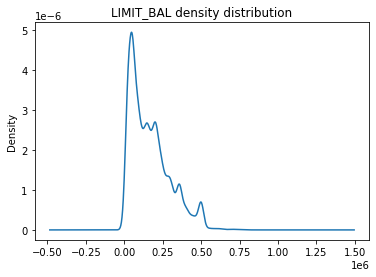

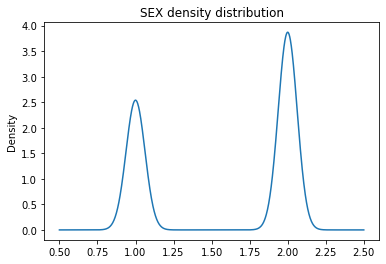

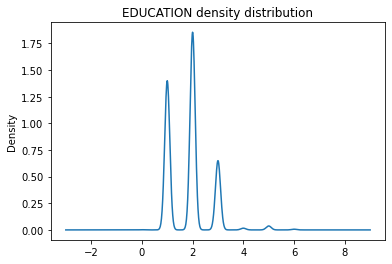

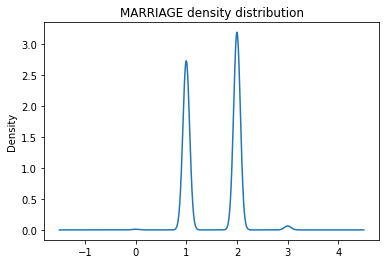

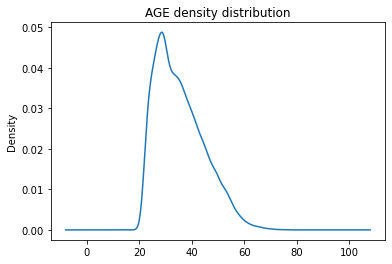

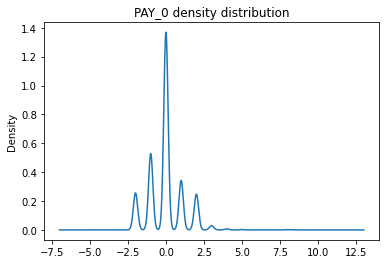

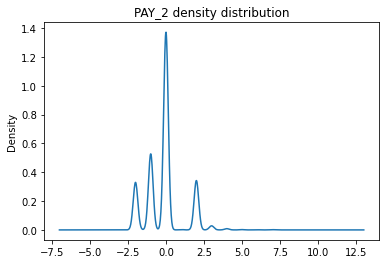

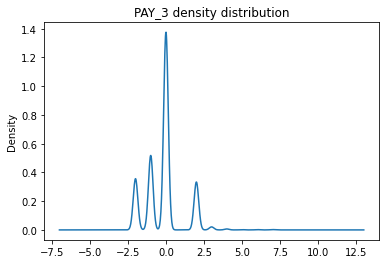

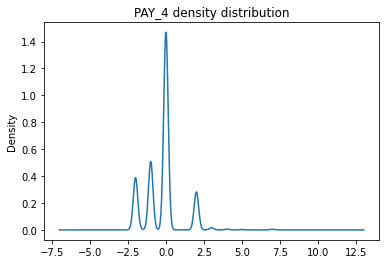

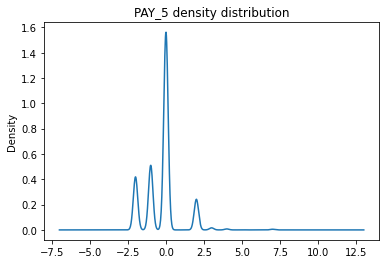

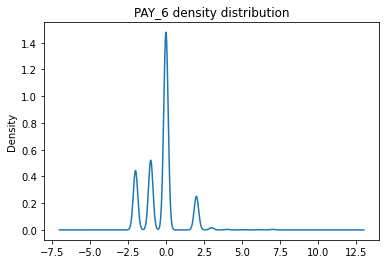

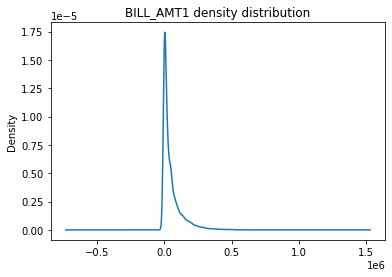

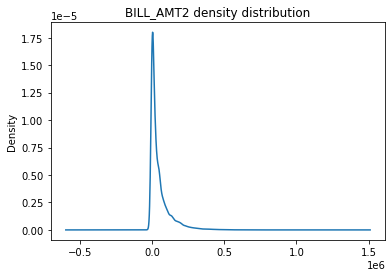

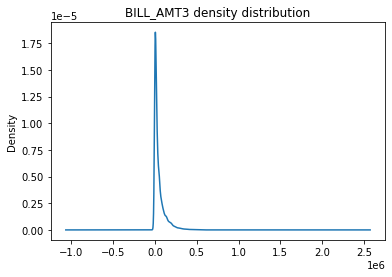

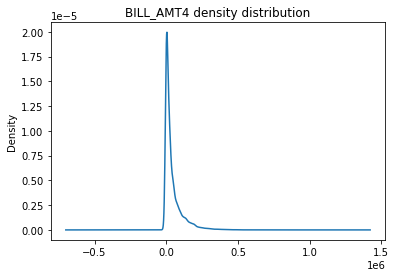

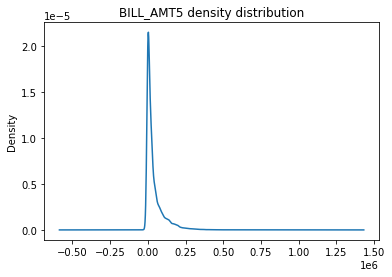

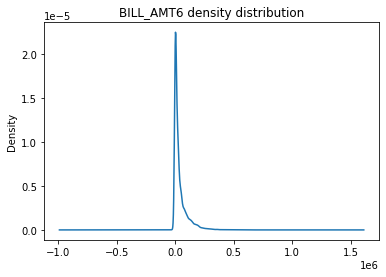

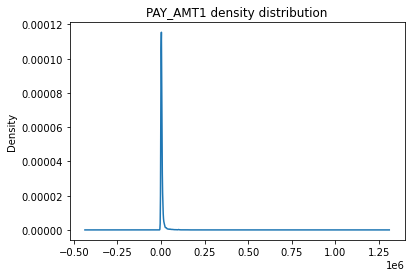

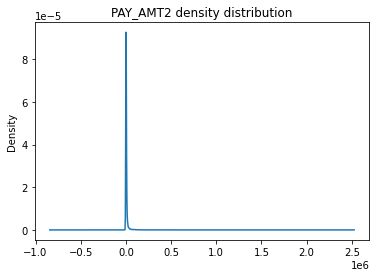

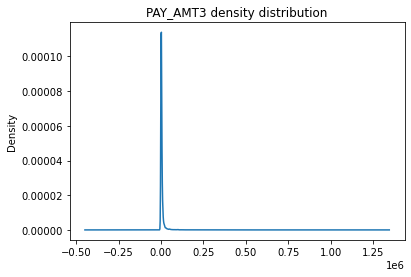

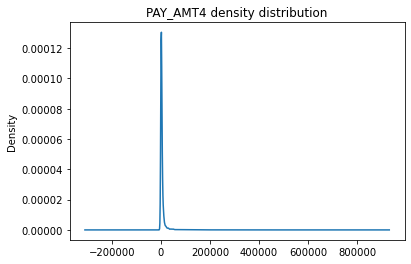

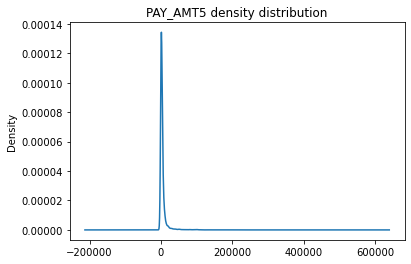

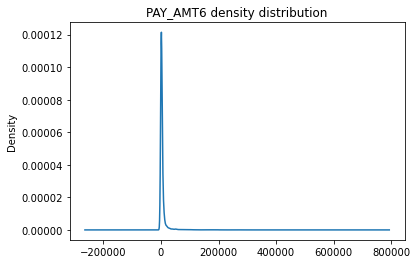

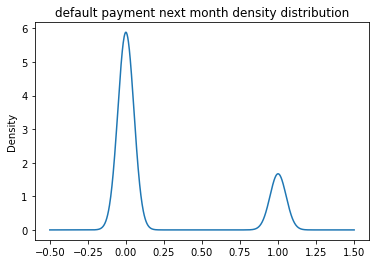

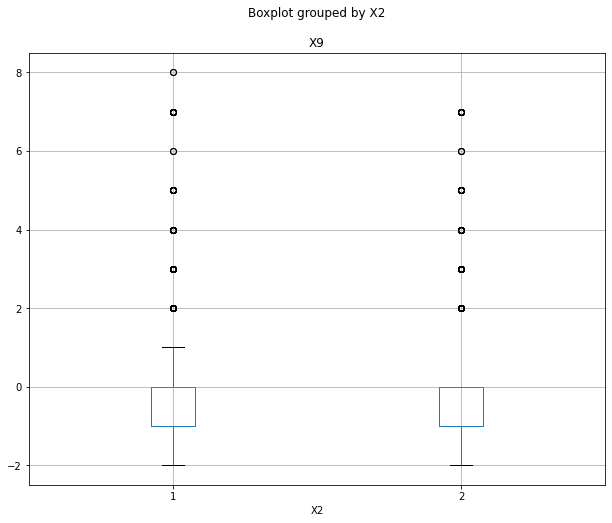

In [24]:
hparams = [{
    'model': LogisticRegression(),
    'hyper_parameters': {
        'penalty': ['l1', 'l2'],
        'C': np.linspace(0.6, 1.4, num=8)
    }
}
]

analyzer = Analyzer(test_dfs_dict['data'], test_dfs_dict['map'], hparams)
analyzer.overview()
analyzer.visualize_2d_feature_relationships('X2', ['X9'])
analyzer.train_models()